In [1]:
# --- Standard libraries
import os.path as osp
import pandas as pd
import numpy as np
import pickle as pkl
# --- Matplotlib
import matplotlib.pyplot as plt
#import imageio
import torch
import torch_geometric
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
# --- XASNet
from XASNet.data import QM9_XAS
from XASNet.data import save_split
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.trainer import GNNTrainer

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3


In [3]:
go_spec = torch.load('./processed/cor_xasnet.pt')

/tmp/ipykernel_17890/3519260758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  go_spec = torch.load('./processed/cor_xasnet.pt')


In [4]:
# --- Print details of the dataset
print(go_spec)
print('------------')
print(f'Number of graphs: {len(go_spec)}')
print(f'Number of features: {go_spec.num_features}')
print('')

# --- Print details of the first molecule/graph in dataset
data = go_spec[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset_mol(317)
------------
Number of graphs: 317
Number of features: 6

Data(x=[32, 6], edge_index=[2, 76], edge_attr=[76, 5], spectrum=[200], idx=[1], smiles='c12[c:2]3[c:1]([H:32])[c:25]([H:41])[c:24]4[c:22]1[c:17]1[c:19]([c:20]([H:39])[c:23]4[H:40])[C:18]([C:21](=[O:26])[O:27][H:42])=[C:16]([H:38])[C:15]4=[C:14]([H:37])[C:12]([H:36])=[C:11]5[C:9]([O:30][H:44])([C:4]2([H:47])[C:6]([O:31][H:46])([C:5]([C:8](=[O:28])[O:29][H:43])=[C:3]3[H:33])[C:7]([H:34])=[C:10]5[H:35])[C:13]41[H:45]')
------------
Number of nodes: 32
Number of edges: 76
Average node degree: 2.38
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [5]:
# --- Create spilt file with the dataset
# --- split into test, validation and test datasets
idxs = save_split(
    path='./processed/xasnet-split.npz',
    ndata=len(go_spec),
    ntrain=238,
    nval=30,
    ntest=49,
    save_split=True,
    shuffle=True, 
    print_nsample=True
)

{'train': 238, 'val': 30, 'test': 49}


In [6]:
# --- Create variables for each dataset split
train_go = [go_spec[i] for i in idxs['train']]
val_go = [go_spec[i] for i in idxs['val']]
test_go = [go_spec[i] for i in idxs['test']]

# train_go = torch.load('./mol_train.pt')
# val_go = torch.load('./mol_val.pt')
# --- Save datasets splits into dataloaders
train_loader = DataLoader(train_go, batch_size=238, shuffle=True)
val_loader = DataLoader(val_go, batch_size=30, shuffle=True)
test_loader = DataLoader(test_go, batch_size=49, shuffle=False)

print(f'Training dataset length: {len(train_go)}, compiled in {len(train_loader)} loaders')
print(f'Validation dataset length: {len(val_go)}, compiled in {len(val_loader)} loaders')
print(f'Test dataset length: {len(test_go)}, compiled in {len(test_loader)} loaders')

torch.save(test_go, './processed/test_cor_xasnet.pt')

Training dataset length: 238, compiled in 1 loaders
Validation dataset length: 30, compiled in 1 loaders
Test dataset length: 49, compiled in 1 loaders


In [7]:
# --- Define cost functions
def RSE_loss(prediction, target):
    dE = (300 - 280) / 200
    nom = torch.sum(dE*torch.pow((target-prediction), 2))
    denom = torch.sum(dE*target)
    return torch.sqrt(nom) / denom 

def RMSE_loss(prediction, target):
    return torch.sqrt(torch.mean((target - prediction)**2))

In [8]:
# --- Set number of epochs to run
num_epochs = 500
# --- Set the learning rate 
lr = 0.01
# --- Milestones to reduce learning rate in steps 
milestones = np.arange(200, 900, 200).tolist()
print(milestones)

[200, 400, 600, 800]


##### XASNet GNN

In [27]:
# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gatv2', # model type
    in_channels = [6, 64, 128], # input nodes for each layer
    out_channels = [64, 128, 256], # output nodes for each layer
    num_targets = 200, # nodes for final output
    num_layers = 3, # number of total layers
    dropout = 0.1,
    heads = 0
).to(device)

# --- Set model name
model_name = 'xasnet_' + xasnet_gnn.gnn_name +'_model'

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

AttributeError: 'NoneType' object has no attribute 'weight'

In [28]:
# --- View the details of the created model
print(xasnet_gnn)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GNN(
  (interaction_layers): ModuleList(
    (0): GraphConv(6, 64)
    (1): ReLU(inplace=True)
    (2): GraphConv(64, 128)
    (3): ReLU(inplace=True)
    (4): GraphConv(128, 256)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=256, out_features=200, bias=True)
)
----
 Model will be trained on: cuda


##### XASNet GAT

In [65]:
# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=8,
    in_channels=[64, 128],
    out_channels=[128, 256],
    targets=200,
    n_layers=2,
    n_heads=4,
    gat_type='gatv2',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Set name for ML model
model_name = 'xasnet-GAT_' + xasnet_gat.gat_type + '_model'

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [66]:
# --- View the details of the created model
print(xasnet_gat)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=8, out_features=64, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (3): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATv2Conv(64, 128, heads=4)
    (1): ReLU(inplace=True)
    (2): GATv2Conv(512, 256, heads=1)
  )
  (lstm): LSTM(512, 128, num_layers=3, batch_first=True, bidirectional=

##### XASNet GraphNet

In [87]:
# --- Set name for ML model
model_name = 'xasnet_graphnet_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=8,
    edge_dim=5,
    hidden_channels=64,
    out_channels=128,
    gat_hidd=64,
    gat_out=128,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [88]:
# --- View the details of the created model
print(xasnet_graphnet)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(8, 64, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(192, 64, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(192, 64, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(192, 128, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=146, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=389, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
         

##### Train model

In [23]:
chosen_model = xasnet_gnn

In [24]:
# --- Set additional ML parameters
optimizer = torch.optim.Adam(chosen_model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.99), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [25]:
# --- Create trainier
trainer = GNNTrainer(model = chosen_model,
                     model_name = model_name,
                     device = device,
                     metric_path = './metrics/' + model_name)

#### Train the ML model        

In [26]:
trainer.train_val(train_loader, val_loader, optimizer, RSE_loss,
                  scheduler, num_epochs, write_every=1, train_graphnet=False)

  2%|▏         | 10/500 [00:00<00:10, 46.59it/s]

time = 0.00 mins mins
epoch 0 | average train loss = 0.000549 and average validation loss = 0.007246 | learning rate = 0.01000
time = 0.00 mins mins
epoch 1 | average train loss = 0.000349 and average validation loss = 0.002222 | learning rate = 0.01000
time = 0.00 mins mins
epoch 2 | average train loss = 0.000105 and average validation loss = 0.001492 | learning rate = 0.01000
time = 0.00 mins mins
epoch 3 | average train loss = 0.000065 and average validation loss = 0.001533 | learning rate = 0.01000
time = 0.00 mins mins
epoch 4 | average train loss = 0.000067 and average validation loss = 0.001506 | learning rate = 0.01000
time = 0.00 mins mins
epoch 5 | average train loss = 0.000066 and average validation loss = 0.001440 | learning rate = 0.01000
time = 0.00 mins mins
epoch 6 | average train loss = 0.000063 and average validation loss = 0.001308 | learning rate = 0.01000
time = 0.00 mins mins
epoch 7 | average train loss = 0.000057 and average validation loss = 0.001071 | learning

  4%|▍         | 20/500 [00:00<00:10, 47.11it/s]

time = 0.00 mins mins
epoch 10 | average train loss = 0.000050 and average validation loss = 0.000853 | learning rate = 0.01000
time = 0.00 mins mins
epoch 11 | average train loss = 0.000037 and average validation loss = 0.000921 | learning rate = 0.01000
time = 0.00 mins mins
epoch 12 | average train loss = 0.000038 and average validation loss = 0.000911 | learning rate = 0.01000
time = 0.01 mins mins
epoch 13 | average train loss = 0.000038 and average validation loss = 0.000695 | learning rate = 0.01000
time = 0.01 mins mins
epoch 14 | average train loss = 0.000029 and average validation loss = 0.000594 | learning rate = 0.01000
time = 0.01 mins mins
epoch 15 | average train loss = 0.000029 and average validation loss = 0.000605 | learning rate = 0.01000
time = 0.01 mins mins
epoch 16 | average train loss = 0.000029 and average validation loss = 0.000566 | learning rate = 0.01000
time = 0.01 mins mins
epoch 17 | average train loss = 0.000025 and average validation loss = 0.000603 | 

  6%|▌         | 30/500 [00:00<00:09, 47.11it/s]

time = 0.01 mins mins
epoch 20 | average train loss = 0.000021 and average validation loss = 0.000461 | learning rate = 0.01000
time = 0.01 mins mins
epoch 21 | average train loss = 0.000022 and average validation loss = 0.000429 | learning rate = 0.01000
time = 0.01 mins mins
epoch 22 | average train loss = 0.000019 and average validation loss = 0.000447 | learning rate = 0.01000
time = 0.01 mins mins
epoch 23 | average train loss = 0.000020 and average validation loss = 0.000415 | learning rate = 0.01000
time = 0.01 mins mins
epoch 24 | average train loss = 0.000019 and average validation loss = 0.000404 | learning rate = 0.01000
time = 0.01 mins mins
epoch 25 | average train loss = 0.000019 and average validation loss = 0.000391 | learning rate = 0.01000
time = 0.01 mins mins
epoch 26 | average train loss = 0.000018 and average validation loss = 0.000372 | learning rate = 0.01000
time = 0.01 mins mins
epoch 27 | average train loss = 0.000018 and average validation loss = 0.000361 | 

  7%|▋         | 35/500 [00:00<00:09, 46.89it/s]

time = 0.01 mins mins
epoch 30 | average train loss = 0.000017 and average validation loss = 0.000362 | learning rate = 0.01000
time = 0.01 mins mins
epoch 31 | average train loss = 0.000017 and average validation loss = 0.000358 | learning rate = 0.01000
time = 0.01 mins mins
epoch 32 | average train loss = 0.000017 and average validation loss = 0.000359 | learning rate = 0.01000
time = 0.01 mins mins
epoch 33 | average train loss = 0.000017 and average validation loss = 0.000355 | learning rate = 0.01000
time = 0.01 mins mins
epoch 34 | average train loss = 0.000017 and average validation loss = 0.000351 | learning rate = 0.01000
time = 0.01 mins mins
epoch 35 | average train loss = 0.000016 and average validation loss = 0.000371 | learning rate = 0.01000
time = 0.01 mins mins
epoch 36 | average train loss = 0.000017 and average validation loss = 0.000367 | learning rate = 0.01000
time = 0.01 mins mins
epoch 37 | average train loss = 0.000017 and average validation loss = 0.000377 | 

  9%|▉         | 47/500 [00:00<00:09, 49.13it/s]

time = 0.01 mins mins
epoch 40 | average train loss = 0.000016 and average validation loss = 0.000429 | learning rate = 0.01000
time = 0.01 mins mins
epoch 41 | average train loss = 0.000019 and average validation loss = 0.000347 | learning rate = 0.01000
time = 0.02 mins mins
epoch 42 | average train loss = 0.000016 and average validation loss = 0.000351 | learning rate = 0.01000
time = 0.02 mins mins
epoch 43 | average train loss = 0.000016 and average validation loss = 0.000353 | learning rate = 0.01000
time = 0.02 mins mins
epoch 44 | average train loss = 0.000016 and average validation loss = 0.000357 | learning rate = 0.01000
time = 0.02 mins mins
epoch 45 | average train loss = 0.000016 and average validation loss = 0.000355 | learning rate = 0.01000
time = 0.02 mins mins
epoch 46 | average train loss = 0.000016 and average validation loss = 0.000353 | learning rate = 0.01000
time = 0.02 mins mins
epoch 47 | average train loss = 0.000016 and average validation loss = 0.000349 | 

 12%|█▏        | 58/500 [00:01<00:08, 50.12it/s]

time = 0.02 mins mins
epoch 51 | average train loss = 0.000016 and average validation loss = 0.000347 | learning rate = 0.01000
time = 0.02 mins mins
epoch 52 | average train loss = 0.000016 and average validation loss = 0.000347 | learning rate = 0.01000
time = 0.02 mins mins
epoch 53 | average train loss = 0.000016 and average validation loss = 0.000346 | learning rate = 0.01000
time = 0.02 mins mins
epoch 54 | average train loss = 0.000015 and average validation loss = 0.000346 | learning rate = 0.01000
time = 0.02 mins mins
epoch 55 | average train loss = 0.000016 and average validation loss = 0.000348 | learning rate = 0.01000
time = 0.02 mins mins
epoch 56 | average train loss = 0.000016 and average validation loss = 0.000349 | learning rate = 0.01000
time = 0.02 mins mins
epoch 57 | average train loss = 0.000015 and average validation loss = 0.000348 | learning rate = 0.01000
time = 0.02 mins mins
epoch 58 | average train loss = 0.000016 and average validation loss = 0.000346 | 

 14%|█▍        | 70/500 [00:01<00:08, 49.96it/s]

time = 0.02 mins mins
epoch 62 | average train loss = 0.000016 and average validation loss = 0.000351 | learning rate = 0.01000
time = 0.02 mins mins
epoch 63 | average train loss = 0.000016 and average validation loss = 0.000348 | learning rate = 0.01000
time = 0.02 mins mins
epoch 64 | average train loss = 0.000016 and average validation loss = 0.000345 | learning rate = 0.01000
time = 0.02 mins mins
epoch 65 | average train loss = 0.000015 and average validation loss = 0.000344 | learning rate = 0.01000
time = 0.02 mins mins
epoch 66 | average train loss = 0.000015 and average validation loss = 0.000345 | learning rate = 0.01000
time = 0.02 mins mins
epoch 67 | average train loss = 0.000015 and average validation loss = 0.000347 | learning rate = 0.01000
time = 0.02 mins mins
epoch 68 | average train loss = 0.000015 and average validation loss = 0.000346 | learning rate = 0.01000
time = 0.02 mins mins
epoch 69 | average train loss = 0.000015 and average validation loss = 0.000344 | 

 16%|█▌        | 80/500 [00:01<00:08, 48.24it/s]

time = 0.03 mins mins
epoch 72 | average train loss = 0.000015 and average validation loss = 0.000342 | learning rate = 0.01000
time = 0.03 mins mins
epoch 73 | average train loss = 0.000015 and average validation loss = 0.000343 | learning rate = 0.01000
time = 0.03 mins mins
epoch 74 | average train loss = 0.000015 and average validation loss = 0.000342 | learning rate = 0.01000
time = 0.03 mins mins
epoch 75 | average train loss = 0.000015 and average validation loss = 0.000340 | learning rate = 0.01000
time = 0.03 mins mins
epoch 76 | average train loss = 0.000015 and average validation loss = 0.000338 | learning rate = 0.01000
time = 0.03 mins mins
epoch 77 | average train loss = 0.000015 and average validation loss = 0.000337 | learning rate = 0.01000
time = 0.03 mins mins
epoch 78 | average train loss = 0.000015 and average validation loss = 0.000337 | learning rate = 0.01000
time = 0.03 mins mins
epoch 79 | average train loss = 0.000015 and average validation loss = 0.000337 | 

 18%|█▊        | 90/500 [00:01<00:08, 48.06it/s]

time = 0.03 mins mins
epoch 82 | average train loss = 0.000015 and average validation loss = 0.000336 | learning rate = 0.01000
time = 0.03 mins mins
epoch 83 | average train loss = 0.000015 and average validation loss = 0.000336 | learning rate = 0.01000
time = 0.03 mins mins
epoch 84 | average train loss = 0.000015 and average validation loss = 0.000335 | learning rate = 0.01000
time = 0.03 mins mins
epoch 85 | average train loss = 0.000015 and average validation loss = 0.000334 | learning rate = 0.01000
time = 0.03 mins mins
epoch 86 | average train loss = 0.000015 and average validation loss = 0.000334 | learning rate = 0.01000
time = 0.03 mins mins
epoch 87 | average train loss = 0.000015 and average validation loss = 0.000333 | learning rate = 0.01000
time = 0.03 mins mins
epoch 88 | average train loss = 0.000015 and average validation loss = 0.000334 | learning rate = 0.01000
time = 0.03 mins mins
epoch 89 | average train loss = 0.000015 and average validation loss = 0.000335 | 

 20%|██        | 101/500 [00:02<00:08, 48.66it/s]

time = 0.03 mins mins
epoch 92 | average train loss = 0.000015 and average validation loss = 0.000330 | learning rate = 0.01000
time = 0.03 mins mins
epoch 93 | average train loss = 0.000015 and average validation loss = 0.000331 | learning rate = 0.01000
time = 0.03 mins mins
epoch 94 | average train loss = 0.000015 and average validation loss = 0.000333 | learning rate = 0.01000
time = 0.03 mins mins
epoch 95 | average train loss = 0.000015 and average validation loss = 0.000332 | learning rate = 0.01000
time = 0.03 mins mins
epoch 96 | average train loss = 0.000015 and average validation loss = 0.000331 | learning rate = 0.01000
time = 0.03 mins mins
epoch 97 | average train loss = 0.000015 and average validation loss = 0.000331 | learning rate = 0.01000
time = 0.03 mins mins
epoch 98 | average train loss = 0.000015 and average validation loss = 0.000330 | learning rate = 0.01000
time = 0.03 mins mins
epoch 99 | average train loss = 0.000015 and average validation loss = 0.000331 | 

 22%|██▏       | 112/500 [00:02<00:07, 49.34it/s]

time = 0.04 mins mins
epoch 103 | average train loss = 0.000015 and average validation loss = 0.000330 | learning rate = 0.01000
time = 0.04 mins mins
epoch 104 | average train loss = 0.000015 and average validation loss = 0.000409 | learning rate = 0.01000
time = 0.04 mins mins
epoch 105 | average train loss = 0.000019 and average validation loss = 0.000340 | learning rate = 0.01000
time = 0.04 mins mins
epoch 106 | average train loss = 0.000015 and average validation loss = 0.000350 | learning rate = 0.01000
time = 0.04 mins mins
epoch 107 | average train loss = 0.000015 and average validation loss = 0.000345 | learning rate = 0.01000
time = 0.04 mins mins
epoch 108 | average train loss = 0.000015 and average validation loss = 0.000333 | learning rate = 0.01000
time = 0.04 mins mins
epoch 109 | average train loss = 0.000015 and average validation loss = 0.000324 | learning rate = 0.01000
time = 0.04 mins mins
epoch 110 | average train loss = 0.000015 and average validation loss = 0.0

 25%|██▍       | 123/500 [00:02<00:07, 49.48it/s]

time = 0.04 mins mins
epoch 114 | average train loss = 0.000015 and average validation loss = 0.000335 | learning rate = 0.01000
time = 0.04 mins mins
epoch 115 | average train loss = 0.000015 and average validation loss = 0.000335 | learning rate = 0.01000
time = 0.04 mins mins
epoch 116 | average train loss = 0.000015 and average validation loss = 0.000333 | learning rate = 0.01000
time = 0.04 mins mins
epoch 117 | average train loss = 0.000015 and average validation loss = 0.000329 | learning rate = 0.01000
time = 0.04 mins mins
epoch 118 | average train loss = 0.000015 and average validation loss = 0.000324 | learning rate = 0.01000
time = 0.04 mins mins
epoch 119 | average train loss = 0.000015 and average validation loss = 0.000322 | learning rate = 0.01000
time = 0.04 mins mins
epoch 120 | average train loss = 0.000015 and average validation loss = 0.000323 | learning rate = 0.01000
time = 0.04 mins mins
epoch 121 | average train loss = 0.000015 and average validation loss = 0.0

 27%|██▋       | 134/500 [00:02<00:07, 49.78it/s]

time = 0.04 mins mins
epoch 125 | average train loss = 0.000015 and average validation loss = 0.000326 | learning rate = 0.01000
time = 0.04 mins mins
epoch 126 | average train loss = 0.000015 and average validation loss = 0.000323 | learning rate = 0.01000
time = 0.04 mins mins
epoch 127 | average train loss = 0.000015 and average validation loss = 0.000320 | learning rate = 0.01000
time = 0.04 mins mins
epoch 128 | average train loss = 0.000015 and average validation loss = 0.000319 | learning rate = 0.01000
time = 0.04 mins mins
epoch 129 | average train loss = 0.000014 and average validation loss = 0.000319 | learning rate = 0.01000
time = 0.04 mins mins
epoch 130 | average train loss = 0.000015 and average validation loss = 0.000321 | learning rate = 0.01000
time = 0.05 mins mins
epoch 131 | average train loss = 0.000015 and average validation loss = 0.000323 | learning rate = 0.01000
time = 0.05 mins mins
epoch 132 | average train loss = 0.000014 and average validation loss = 0.0

 29%|██▉       | 144/500 [00:02<00:07, 47.55it/s]

time = 0.05 mins mins
epoch 135 | average train loss = 0.000015 and average validation loss = 0.000319 | learning rate = 0.01000
time = 0.05 mins mins
epoch 136 | average train loss = 0.000015 and average validation loss = 0.000315 | learning rate = 0.01000
time = 0.05 mins mins
epoch 137 | average train loss = 0.000014 and average validation loss = 0.000315 | learning rate = 0.01000
time = 0.05 mins mins
epoch 138 | average train loss = 0.000014 and average validation loss = 0.000316 | learning rate = 0.01000
time = 0.05 mins mins
epoch 139 | average train loss = 0.000014 and average validation loss = 0.000317 | learning rate = 0.01000
time = 0.05 mins mins
epoch 140 | average train loss = 0.000014 and average validation loss = 0.000315 | learning rate = 0.01000
time = 0.05 mins mins
epoch 141 | average train loss = 0.000014 and average validation loss = 0.000313 | learning rate = 0.01000
time = 0.05 mins mins
epoch 142 | average train loss = 0.000014 and average validation loss = 0.0

 31%|███       | 154/500 [00:03<00:07, 47.96it/s]

time = 0.05 mins mins
epoch 145 | average train loss = 0.000014 and average validation loss = 0.000308 | learning rate = 0.01000
time = 0.05 mins mins
epoch 146 | average train loss = 0.000014 and average validation loss = 0.000308 | learning rate = 0.01000
time = 0.05 mins mins
epoch 147 | average train loss = 0.000014 and average validation loss = 0.000310 | learning rate = 0.01000
time = 0.05 mins mins
epoch 148 | average train loss = 0.000014 and average validation loss = 0.000310 | learning rate = 0.01000
time = 0.05 mins mins
epoch 149 | average train loss = 0.000014 and average validation loss = 0.000309 | learning rate = 0.01000
time = 0.05 mins mins
epoch 150 | average train loss = 0.000014 and average validation loss = 0.000308 | learning rate = 0.01000
time = 0.05 mins mins
epoch 151 | average train loss = 0.000014 and average validation loss = 0.000308 | learning rate = 0.01000
time = 0.05 mins mins
epoch 152 | average train loss = 0.000014 and average validation loss = 0.0

 33%|███▎      | 164/500 [00:03<00:07, 47.83it/s]

time = 0.05 mins mins
epoch 155 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.05 mins mins
epoch 156 | average train loss = 0.000014 and average validation loss = 0.000304 | learning rate = 0.01000
time = 0.05 mins mins
epoch 157 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.05 mins mins
epoch 158 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 159 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 160 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 161 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 162 | average train loss = 0.000014 and average validation loss = 0.0

 35%|███▌      | 175/500 [00:03<00:06, 49.04it/s]

time = 0.06 mins mins
epoch 165 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 166 | average train loss = 0.000014 and average validation loss = 0.000313 | learning rate = 0.01000
time = 0.06 mins mins
epoch 167 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 168 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 169 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 170 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 171 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 172 | average train loss = 0.000014 and average validation loss = 0.0

 37%|███▋      | 185/500 [00:03<00:06, 48.19it/s]

time = 0.06 mins mins
epoch 176 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.01000
time = 0.06 mins mins
epoch 177 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 178 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 179 | average train loss = 0.000014 and average validation loss = 0.000305 | learning rate = 0.01000
time = 0.06 mins mins
epoch 180 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.01000
time = 0.06 mins mins
epoch 181 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.06 mins mins
epoch 182 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.06 mins mins
epoch 183 | average train loss = 0.000014 and average validation loss = 0.0

 39%|███▉      | 195/500 [00:04<00:06, 48.54it/s]

time = 0.06 mins mins
epoch 186 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.06 mins mins
epoch 187 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.07 mins mins
epoch 188 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.07 mins mins
epoch 189 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.07 mins mins
epoch 190 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.01000
time = 0.07 mins mins
epoch 191 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.07 mins mins
epoch 192 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.07 mins mins
epoch 193 | average train loss = 0.000014 and average validation loss = 0.0

 41%|████      | 205/500 [00:04<00:06, 48.20it/s]

time = 0.07 mins mins
epoch 196 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.01000
time = 0.07 mins mins
epoch 197 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.01000
time = 0.07 mins mins
epoch 198 | average train loss = 0.000014 and average validation loss = 0.000303 | learning rate = 0.01000
time = 0.07 mins mins
epoch 199 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.00800
time = 0.07 mins mins
epoch 200 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.07 mins mins
epoch 201 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.07 mins mins
epoch 202 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.07 mins mins
epoch 203 | average train loss = 0.000014 and average validation loss = 0.0

 43%|████▎     | 216/500 [00:04<00:05, 48.72it/s]

time = 0.07 mins mins
epoch 206 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.07 mins mins
epoch 207 | average train loss = 0.000013 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.07 mins mins
epoch 208 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.07 mins mins
epoch 209 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.07 mins mins
epoch 210 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.07 mins mins
epoch 211 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.07 mins mins
epoch 212 | average train loss = 0.000014 and average validation loss = 0.000302 | learning rate = 0.00800
time = 0.07 mins mins
epoch 213 | average train loss = 0.000014 and average validation loss = 0.0

 45%|████▌     | 226/500 [00:04<00:05, 48.69it/s]

time = 0.07 mins mins
epoch 216 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 217 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 218 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 219 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.08 mins mins
epoch 220 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.08 mins mins
epoch 221 | average train loss = 0.000014 and average validation loss = 0.000301 | learning rate = 0.00800
time = 0.08 mins mins
epoch 222 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 223 | average train loss = 0.000014 and average validation loss = 0.0

 47%|████▋     | 237/500 [00:04<00:05, 49.60it/s]

time = 0.08 mins mins
epoch 226 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 227 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 228 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 229 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 230 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 231 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 232 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 233 | average train loss = 0.000013 and average validation loss = 0.0

 48%|████▊     | 242/500 [00:04<00:05, 49.13it/s]

time = 0.08 mins mins
epoch 237 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.08 mins mins
epoch 238 | average train loss = 0.000013 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 239 | average train loss = 0.000013 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 240 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 241 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 242 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 243 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.08 mins mins
epoch 244 | average train loss = 0.000014 and average validation loss = 0.0

 51%|█████     | 253/500 [00:05<00:05, 48.32it/s]

time = 0.09 mins mins
epoch 247 | average train loss = 0.000014 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 248 | average train loss = 0.000014 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 249 | average train loss = 0.000014 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 250 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 251 | average train loss = 0.000013 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 252 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 253 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 254 | average train loss = 0.000014 and average validation loss = 0.0

 53%|█████▎    | 264/500 [00:05<00:04, 48.17it/s]

time = 0.09 mins mins
epoch 257 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 258 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 259 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 260 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 261 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 262 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 263 | average train loss = 0.000014 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.09 mins mins
epoch 264 | average train loss = 0.000013 and average validation loss = 0.0

 55%|█████▍    | 274/500 [00:05<00:04, 47.49it/s]

time = 0.09 mins mins
epoch 267 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.09 mins mins
epoch 268 | average train loss = 0.000014 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 269 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.09 mins mins
epoch 270 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.09 mins mins
epoch 271 | average train loss = 0.000014 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.09 mins mins
epoch 272 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.09 mins mins
epoch 273 | average train loss = 0.000013 and average validation loss = 0.000299 | learning rate = 0.00800
time = 0.09 mins mins
epoch 274 | average train loss = 0.000013 and average validation loss = 0.0

 57%|█████▋    | 284/500 [00:05<00:04, 47.61it/s]

time = 0.10 mins mins
epoch 277 | average train loss = 0.000014 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.10 mins mins
epoch 278 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.10 mins mins
epoch 279 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.10 mins mins
epoch 280 | average train loss = 0.000013 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 281 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.10 mins mins
epoch 282 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.10 mins mins
epoch 283 | average train loss = 0.000014 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.10 mins mins
epoch 284 | average train loss = 0.000014 and average validation loss = 0.0

 59%|█████▉    | 295/500 [00:06<00:04, 48.65it/s]

time = 0.10 mins mins
epoch 287 | average train loss = 0.000014 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 288 | average train loss = 0.000013 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 289 | average train loss = 0.000014 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 290 | average train loss = 0.000013 and average validation loss = 0.000298 | learning rate = 0.00800
time = 0.10 mins mins
epoch 291 | average train loss = 0.000013 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.10 mins mins
epoch 292 | average train loss = 0.000014 and average validation loss = 0.000300 | learning rate = 0.00800
time = 0.10 mins mins
epoch 293 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.10 mins mins
epoch 294 | average train loss = 0.000013 and average validation loss = 0.0

 61%|██████    | 306/500 [00:06<00:03, 48.77it/s]

time = 0.10 mins mins
epoch 298 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.10 mins mins
epoch 299 | average train loss = 0.000013 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 300 | average train loss = 0.000013 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.10 mins mins
epoch 301 | average train loss = 0.000013 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.10 mins mins
epoch 302 | average train loss = 0.000013 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.10 mins mins
epoch 303 | average train loss = 0.000013 and average validation loss = 0.000296 | learning rate = 0.00800
time = 0.11 mins mins
epoch 304 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.11 mins mins
epoch 305 | average train loss = 0.000013 and average validation loss = 0.0

 63%|██████▎   | 317/500 [00:06<00:03, 48.95it/s]

time = 0.11 mins mins
epoch 308 | average train loss = 0.000013 and average validation loss = 0.000292 | learning rate = 0.00800
time = 0.11 mins mins
epoch 309 | average train loss = 0.000013 and average validation loss = 0.000302 | learning rate = 0.00800
time = 0.11 mins mins
epoch 310 | average train loss = 0.000013 and average validation loss = 0.000302 | learning rate = 0.00800
time = 0.11 mins mins
epoch 311 | average train loss = 0.000013 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.11 mins mins
epoch 312 | average train loss = 0.000013 and average validation loss = 0.000293 | learning rate = 0.00800
time = 0.11 mins mins
epoch 313 | average train loss = 0.000013 and average validation loss = 0.000294 | learning rate = 0.00800
time = 0.11 mins mins
epoch 314 | average train loss = 0.000013 and average validation loss = 0.000297 | learning rate = 0.00800
time = 0.11 mins mins
epoch 315 | average train loss = 0.000013 and average validation loss = 0.0

 65%|██████▌   | 327/500 [00:06<00:03, 47.29it/s]

time = 0.11 mins mins
epoch 318 | average train loss = 0.000013 and average validation loss = 0.000293 | learning rate = 0.00800
time = 0.11 mins mins
epoch 319 | average train loss = 0.000013 and average validation loss = 0.000294 | learning rate = 0.00800
time = 0.11 mins mins
epoch 320 | average train loss = 0.000013 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.11 mins mins
epoch 321 | average train loss = 0.000013 and average validation loss = 0.000295 | learning rate = 0.00800
time = 0.11 mins mins
epoch 322 | average train loss = 0.000013 and average validation loss = 0.000291 | learning rate = 0.00800
time = 0.11 mins mins
epoch 323 | average train loss = 0.000013 and average validation loss = 0.000289 | learning rate = 0.00800
time = 0.11 mins mins
epoch 324 | average train loss = 0.000013 and average validation loss = 0.000289 | learning rate = 0.00800
time = 0.11 mins mins
epoch 325 | average train loss = 0.000013 and average validation loss = 0.0

 67%|██████▋   | 337/500 [00:06<00:03, 46.69it/s]

time = 0.11 mins mins
epoch 328 | average train loss = 0.000013 and average validation loss = 0.000290 | learning rate = 0.00800
time = 0.11 mins mins
epoch 329 | average train loss = 0.000013 and average validation loss = 0.000288 | learning rate = 0.00800
time = 0.11 mins mins
epoch 330 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.11 mins mins
epoch 331 | average train loss = 0.000013 and average validation loss = 0.000289 | learning rate = 0.00800
time = 0.12 mins mins
epoch 332 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.12 mins mins
epoch 333 | average train loss = 0.000013 and average validation loss = 0.000286 | learning rate = 0.00800
time = 0.12 mins mins
epoch 334 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.12 mins mins
epoch 335 | average train loss = 0.000013 and average validation loss = 0.0

 69%|██████▉   | 347/500 [00:07<00:03, 46.58it/s]

time = 0.12 mins mins
epoch 338 | average train loss = 0.000013 and average validation loss = 0.000286 | learning rate = 0.00800
time = 0.12 mins mins
epoch 339 | average train loss = 0.000013 and average validation loss = 0.000286 | learning rate = 0.00800
time = 0.12 mins mins
epoch 340 | average train loss = 0.000013 and average validation loss = 0.000288 | learning rate = 0.00800
time = 0.12 mins mins
epoch 341 | average train loss = 0.000013 and average validation loss = 0.000285 | learning rate = 0.00800
time = 0.12 mins mins
epoch 342 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.12 mins mins
epoch 343 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.12 mins mins
epoch 344 | average train loss = 0.000013 and average validation loss = 0.000288 | learning rate = 0.00800
time = 0.12 mins mins
epoch 345 | average train loss = 0.000013 and average validation loss = 0.0

 71%|███████▏  | 357/500 [00:07<00:03, 47.56it/s]

time = 0.12 mins mins
epoch 348 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.12 mins mins
epoch 349 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.12 mins mins
epoch 350 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.12 mins mins
epoch 351 | average train loss = 0.000013 and average validation loss = 0.000286 | learning rate = 0.00800
time = 0.12 mins mins
epoch 352 | average train loss = 0.000013 and average validation loss = 0.000285 | learning rate = 0.00800
time = 0.12 mins mins
epoch 353 | average train loss = 0.000013 and average validation loss = 0.000287 | learning rate = 0.00800
time = 0.12 mins mins
epoch 354 | average train loss = 0.000013 and average validation loss = 0.000285 | learning rate = 0.00800
time = 0.12 mins mins
epoch 355 | average train loss = 0.000013 and average validation loss = 0.0

 73%|███████▎  | 367/500 [00:07<00:02, 46.89it/s]

time = 0.12 mins mins
epoch 358 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.12 mins mins
epoch 359 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.12 mins mins
epoch 360 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 361 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 362 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 363 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 364 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.13 mins mins
epoch 365 | average train loss = 0.000013 and average validation loss = 0.0

 75%|███████▌  | 377/500 [00:07<00:02, 46.67it/s]

time = 0.13 mins mins
epoch 368 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 369 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 370 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00800
time = 0.13 mins mins
epoch 371 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 372 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 373 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 374 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 375 | average train loss = 0.000013 and average validation loss = 0.0

 77%|███████▋  | 387/500 [00:08<00:02, 47.25it/s]

time = 0.13 mins mins
epoch 378 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00800
time = 0.13 mins mins
epoch 379 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.13 mins mins
epoch 380 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00800
time = 0.13 mins mins
epoch 381 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00800
time = 0.13 mins mins
epoch 382 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.13 mins mins
epoch 383 | average train loss = 0.000013 and average validation loss = 0.000285 | learning rate = 0.00800
time = 0.13 mins mins
epoch 384 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00800
time = 0.13 mins mins
epoch 385 | average train loss = 0.000013 and average validation loss = 0.0

 79%|███████▉  | 397/500 [00:08<00:02, 47.25it/s]

time = 0.13 mins mins
epoch 388 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.14 mins mins
epoch 389 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00800
time = 0.14 mins mins
epoch 390 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00800
time = 0.14 mins mins
epoch 391 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.14 mins mins
epoch 392 | average train loss = 0.000013 and average validation loss = 0.000284 | learning rate = 0.00800
time = 0.14 mins mins
epoch 393 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00800
time = 0.14 mins mins
epoch 394 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00800
time = 0.14 mins mins
epoch 395 | average train loss = 0.000013 and average validation loss = 0.0

 81%|████████▏ | 407/500 [00:08<00:01, 47.00it/s]

time = 0.14 mins mins
epoch 398 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00800
time = 0.14 mins mins
epoch 399 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.14 mins mins
epoch 400 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.14 mins mins
epoch 401 | average train loss = 0.000012 and average validation loss = 0.000283 | learning rate = 0.00640
time = 0.14 mins mins
epoch 402 | average train loss = 0.000013 and average validation loss = 0.000286 | learning rate = 0.00640
time = 0.14 mins mins
epoch 403 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00640
time = 0.14 mins mins
epoch 404 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.14 mins mins
epoch 405 | average train loss = 0.000013 and average validation loss = 0.0

 83%|████████▎ | 417/500 [00:08<00:01, 47.80it/s]

time = 0.14 mins mins
epoch 408 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00640
time = 0.14 mins mins
epoch 409 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.14 mins mins
epoch 410 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.14 mins mins
epoch 411 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.14 mins mins
epoch 412 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.14 mins mins
epoch 413 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.14 mins mins
epoch 414 | average train loss = 0.000013 and average validation loss = 0.000283 | learning rate = 0.00640
time = 0.14 mins mins
epoch 415 | average train loss = 0.000013 and average validation loss = 0.0

 85%|████████▌ | 427/500 [00:08<00:01, 47.97it/s]

time = 0.15 mins mins
epoch 418 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 419 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00640
time = 0.15 mins mins
epoch 420 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 421 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 422 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 423 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 424 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 425 | average train loss = 0.000012 and average validation loss = 0.0

 87%|████████▋ | 437/500 [00:09<00:01, 48.09it/s]

time = 0.15 mins mins
epoch 428 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 429 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 430 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 431 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 432 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.15 mins mins
epoch 433 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 434 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.15 mins mins
epoch 435 | average train loss = 0.000013 and average validation loss = 0.0

 89%|████████▉ | 447/500 [00:09<00:01, 47.18it/s]

time = 0.15 mins mins
epoch 438 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 439 | average train loss = 0.000013 and average validation loss = 0.000282 | learning rate = 0.00640
time = 0.15 mins mins
epoch 440 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 441 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.15 mins mins
epoch 442 | average train loss = 0.000013 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.15 mins mins
epoch 443 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.15 mins mins
epoch 444 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.15 mins mins
epoch 445 | average train loss = 0.000013 and average validation loss = 0.0

 91%|█████████▏| 457/500 [00:09<00:00, 47.13it/s]

time = 0.16 mins mins
epoch 448 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 449 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 450 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.16 mins mins
epoch 451 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.16 mins mins
epoch 452 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 453 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 454 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 455 | average train loss = 0.000013 and average validation loss = 0.0

 93%|█████████▎| 467/500 [00:09<00:00, 47.22it/s]

time = 0.16 mins mins
epoch 458 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.16 mins mins
epoch 459 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 460 | average train loss = 0.000013 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 461 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.16 mins mins
epoch 462 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 463 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.16 mins mins
epoch 464 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.16 mins mins
epoch 465 | average train loss = 0.000012 and average validation loss = 0.0

 95%|█████████▌| 477/500 [00:09<00:00, 47.08it/s]

time = 0.16 mins mins
epoch 468 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.16 mins mins
epoch 469 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.16 mins mins
epoch 470 | average train loss = 0.000012 and average validation loss = 0.000277 | learning rate = 0.00640
time = 0.16 mins mins
epoch 471 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.16 mins mins
epoch 472 | average train loss = 0.000012 and average validation loss = 0.000282 | learning rate = 0.00640
time = 0.16 mins mins
epoch 473 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.17 mins mins
epoch 474 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.17 mins mins
epoch 475 | average train loss = 0.000012 and average validation loss = 0.0

 97%|█████████▋| 487/500 [00:10<00:00, 46.43it/s]

time = 0.17 mins mins
epoch 478 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.17 mins mins
epoch 479 | average train loss = 0.000013 and average validation loss = 0.000277 | learning rate = 0.00640
time = 0.17 mins mins
epoch 480 | average train loss = 0.000012 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.17 mins mins
epoch 481 | average train loss = 0.000012 and average validation loss = 0.000277 | learning rate = 0.00640
time = 0.17 mins mins
epoch 482 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.17 mins mins
epoch 483 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.17 mins mins
epoch 484 | average train loss = 0.000012 and average validation loss = 0.000280 | learning rate = 0.00640
time = 0.17 mins mins
epoch 485 | average train loss = 0.000013 and average validation loss = 0.0

 99%|█████████▉| 497/500 [00:10<00:00, 46.92it/s]

time = 0.17 mins mins
epoch 488 | average train loss = 0.000012 and average validation loss = 0.000283 | learning rate = 0.00640
time = 0.17 mins mins
epoch 489 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.17 mins mins
epoch 490 | average train loss = 0.000013 and average validation loss = 0.000276 | learning rate = 0.00640
time = 0.17 mins mins
epoch 491 | average train loss = 0.000012 and average validation loss = 0.000277 | learning rate = 0.00640
time = 0.17 mins mins
epoch 492 | average train loss = 0.000013 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.17 mins mins
epoch 493 | average train loss = 0.000012 and average validation loss = 0.000281 | learning rate = 0.00640
time = 0.17 mins mins
epoch 494 | average train loss = 0.000013 and average validation loss = 0.000278 | learning rate = 0.00640
time = 0.17 mins mins
epoch 495 | average train loss = 0.000012 and average validation loss = 0.0

100%|██████████| 500/500 [00:10<00:00, 47.86it/s]

time = 0.17 mins mins
epoch 498 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640
time = 0.17 mins mins
epoch 499 | average train loss = 0.000012 and average validation loss = 0.000279 | learning rate = 0.00640


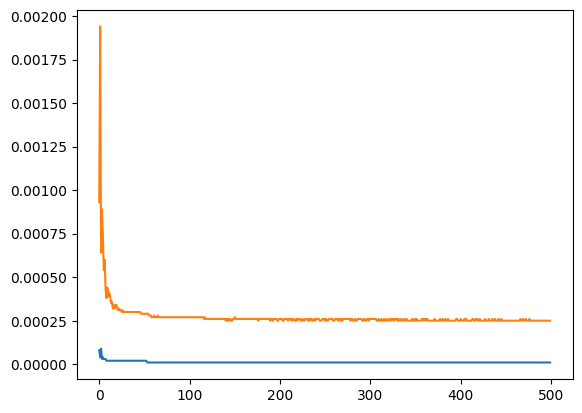

In [33]:
df_train = pd.read_csv('./metrics/' + model_name + '/train_metrics.csv')
df_val = pd.read_csv('./metrics/' + model_name + '/val_metrics.csv')
plt.plot(df_train['epoch'], df_train['loss'])
plt.plot(df_val['epoch'], df_val['loss'])
plt.show()